<a href="https://colab.research.google.com/github/Royal4224/ENM_5320/blob/main/Code/Lecture01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook will provide a warmup to make sure everyone is familiar with the basics of PyTorch at the level necessary for this class. These notes were adapted from an undergraduate class - while the explanations may be non-mathematical, this should provide enough of the basics to get you going. The first homework assignment is given at the end of this notebook.

## Introduction to pickle as a way to load in and save data ##

First, we are going to need some tools to build datasets and save them to disk. There are more sophisticated tools (typically one would work with [Pandas dataframes](https://pandas.pydata.org/) in a more serious data science setting), but we will use [Pickle](https://docs.python.org/3/library/pickle.html) to get started because it is incredibly simple to use and is fast for relatively small datasets. For very large datasets Pickle won't cut it - we will eventually use things like [HDF5](https://docs.h5py.org/en/stable/) for storing large computational meshes. As always, when learning a new library you will find it useful to keep a LLM open in your browser to help answer specific questions about syntax.

Pickle will take *any python object* and save it to disk as a `.pkl` file (pronounced "pickle"). There are three key functions to understand:
* `open`: Open up a pickle file. The first argument is the file name, and the second argument sets whether to open the file in read or write mode.
* `pickle.dump`: Pushes the object into the pkl file. The first argument is the python object, while the second is the opened pkl file.
* `pickle.load`: Loads the pkl file from disk. The argument is the opened pkl file.

This makes it easy to make sure you don't use an object by accident outside of a certain place. In the example code below, we use `with` to make sure our pickle file is in either write mode (`'wb'`) or read mode (`'rb'`).

Example code is below:

In [2]:
import numpy as np
import pickle

# Create a list of NumPy arrays
array_list = [np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])]

# Save the list of NumPy arrays to a file
with open('array_list.pkl', 'wb') as filename:
    pickle.dump(array_list, filename)

# Load the list of NumPy arrays from the file
with open('array_list.pkl', 'rb') as filename:
    loaded_array_list = pickle.load(filename)

# Verify the loaded data
for i, array in enumerate(loaded_array_list):
    print(f"Array {i}:", array)

Array 0: [1 2 3]
Array 1: [4 5 6]
Array 2: [7 8 9]


## Introduction to PyTorch ##

Today we'll learn to use pytorch as a tool to perform automatic differentiation (AD). AD is powerful, because it allows us to take the derivatives of very complex functions and use those derivatives in optimizers without needing to calculate anything by hand, opening up paths to models that would historically be considered too complex. We start by understanding how to work with tensors atomistically before we start using them in computations.

**Tensor syntax.** PyTorch operates on tensors, which you can think of as no different from numpy array, but that they have the "plumbing" in place to do automatic differentiation. The following gives some examples of how you can build tensors and interact with them - it is nearly identical to numpy.

In [1]:
import torch

# Create PyTorch tensors
tensor_a = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
tensor_b = torch.tensor([[5, 6], [7, 8]], dtype=torch.float32)

# Transpose
tensor_transpose = tensor_a.t()

# Reshape
tensor_reshape = tensor_a.view(4, 1)

# Slicing
tensor_slice = tensor_a[:, 1]

# Concatenation - dim states which dimension to concatenate in (i.e. stack in rows vs stack in columns)
tensor_concat = torch.cat((tensor_a, tensor_b), dim=0)

# Sum
tensor_sum = torch.sum(tensor_a)

# Mean
tensor_mean = torch.mean(tensor_a)

# Element-wise sine
tensor_sin = torch.sin(tensor_a)

# Norm
tensor_norm = torch.norm(tensor_a)

# In-place addition
tensor_a.add_(tensor_b)

print("Transpose:\n", tensor_transpose)
print("Reshape:\n", tensor_reshape)
print("Slicing:\n", tensor_slice)
print("Concatenation:\n", tensor_concat)
print("Sum:\n", tensor_sum)
print("Mean:\n", tensor_mean)
print("Element-wise Sine:\n", tensor_sin)
print("Norm:\n", tensor_norm)
print("In-place Addition:\n", tensor_a)

Transpose:
 tensor([[ 6., 10.],
        [ 8., 12.]])
Reshape:
 tensor([[ 6.],
        [ 8.],
        [10.],
        [12.]])
Slicing:
 tensor([ 8., 12.])
Concatenation:
 tensor([[1., 2.],
        [3., 4.],
        [5., 6.],
        [7., 8.]])
Sum:
 tensor(10.)
Mean:
 tensor(2.5000)
Element-wise Sine:
 tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568]])
Norm:
 tensor(5.4772)
In-place Addition:
 tensor([[ 6.,  8.],
        [10., 12.]])


**Taking derivatives.** The following code implements a very simple polynomial function and takes its derivative. For this there are a few parts to pay careful attention to:
* `Requires_grad=True` when defining `x` is important, because it tells PyTorch to track future variables which depend on `x` - this is the cue to start building up the computational graph for building derivatives.
* `y.backward` builds up the derivatives with respect to all variables that `y` depends upon which were initialized with the `requires_grad` flag.
* `x.grad` returns the computed derivative.

In [2]:
import torch

# Create a tensor with requires_grad=True to track computations
x = torch.tensor(2.0, requires_grad=True)

# Perform some operations
y = x ** 2 + 3 * x + 1

# Compute the gradient
y.backward()

# Print the gradient
print("Gradient of y with respect to x:", x.grad)

Gradient of y with respect to x: tensor(7.)


**Zeroing out the gradients.**
To make things fast, PyTorch accumulates gradients on the fly. This is because when performing the chain rule, many derivatives are aggregated across the model over and over. This means however that you need to "clear the buffer" before calculating a derivative a second time. The following code illustrates this.

In [3]:
# Define a simple function
def f(x):
    return x ** 2

# Initialize the tensor with requires_grad=True
x = torch.tensor(2.0, requires_grad=True)

# Perform the first backward pass
y = f(x)
y.backward()
print("Gradient after first backward pass:", x.grad)

# Perform the second backward pass without zeroing gradients
y = f(x)
y.backward()
print("Gradient after second backward pass without zeroing:", x.grad)

# Zero the gradients
x.grad.zero_()

# Perform the third backward pass after zeroing gradients
y = f(x)
y.backward()
print("Gradient after third backward pass with zeroing:", x.grad)

Gradient after first backward pass: tensor(4.)
Gradient after second backward pass without zeroing: tensor(8.)
Gradient after third backward pass with zeroing: tensor(4.)


**Detaching tensors from the graph.** Pytorch will track every variable as you build up more and more complicated expressions. Sometimes though, you just want to do some operations on a function that don't need derivatives (e.g. you want to make some plots) or you may want to neglect dependence on certain models when computing gradients. For this you can use the `detach()` function.

In [4]:
# Create a tensor with requires_grad=True
x = torch.tensor(5.0, requires_grad=True)

# Perform some operations
y1 = x ** 2 + 3 * x + 1
y2 = 2 * x

# Take the derivative of y1 + y2
y = y1 + y2
y.backward(retain_graph=True)
print("Gradient of y with respect to x without detaching y2:", x.grad)

x.grad.zero_()

# Take the derivative of y1 only
y_skipy2 = y1 + y2.detach()
y_skipy2.backward(retain_graph=True)
print("Gradient of y with respect to x after detaching y2:", x.grad)


Gradient of y with respect to x without detaching y2: tensor(15.)
Gradient of y with respect to x after detaching y2: tensor(13.)


**Going back and forth between numpy.** It is possible to interpret pytorch tensors as numpy arrays and vice versa.

In [6]:
import torch
import numpy as np

# Create a PyTorch tensor
tensor = torch.tensor([1.0, 2.0, 3.0])

# Convert PyTorch tensor to NumPy array
numpy_array = tensor.numpy()
print("NumPy array:", numpy_array)

# Convert NumPy array back to PyTorch tensor
tensor_from_numpy = torch.from_numpy(numpy_array)
print("PyTorch tensor from NumPy array:", tensor_from_numpy)

NumPy array: [1. 2. 3.]
PyTorch tensor from NumPy array: tensor([1., 2., 3.])


**Example - Generating plots of PyTorch variables.** The following code will generate a plot of a polynomial function and gives examples of how to use `numpy()` and `detach()` when making plots.

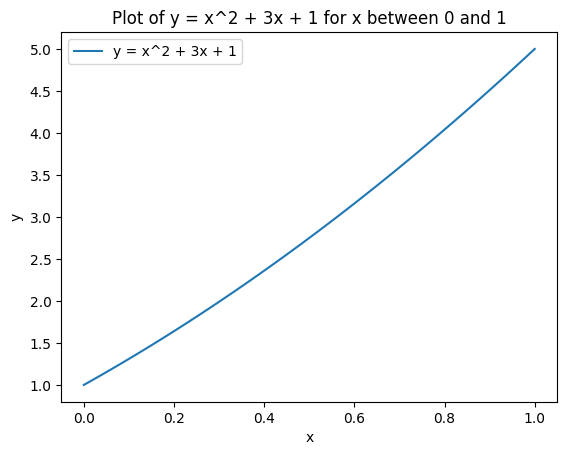

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def f(x):
    return x ** 2 + 3 * x + 1

# Generate x values between 0 and 1
x_values = torch.linspace(0, 1, steps=100, requires_grad=True)

# Compute y values
y_values = f(x_values)

# Plot the function
#   Note: we use detach() here because we don't need derivatives of plots with respect to inputs
plt.plot(x_values.detach().numpy(), y_values.detach().numpy(), label='y = x^2 + 3x + 1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = x^2 + 3x + 1 for x between 0 and 1')
plt.legend()
plt.show()

## Introduction to gradient descent using automatic differentiation ##

Let's take what we've used so far and use it to solve nonlinear systems of equations
$$F(x) = 0 $$

Recall the update formula for a quasi-Newton method.
$$x_{n+1} = x_n - \frac{F (x_n)}{F' (x_n)}$$
Remember also that if we instead want to minimize a function
$$\underset{x}{\min}\, G(x)$$
that amounts to setting the first derivative to zero

$$G'(x) = 0$$

in which case Newton reduces to
$$x_{n+1} = x_n - \frac{G'(x_n)}{G''(x_n)}$$
This requires taking two derivatives. For very simple loss functions like least squares problems, these gradients are simple to compute and can be done by hand - this is why these classes of optimization problems have dominated applied math. It's because they're tractable to work analytically - not because they're necessarily the best formulation.

Let's do a simple example to see how quickly the second derivatives get out of hand, for even a moderately complex function:

$$G(x) = \frac{\sin \left[\exp \left( \cos x^2 \right)^3\right] }{\cos \left[\exp -\left( \tan x^4 \right)^2 \right]}$$
The derivative has many terms, even after simplifying:
$$G'(x) = \frac{
    \cos \left( \exp \left( \cos x^2 \right)^3 \right) \cdot \left( \exp \left( \cos x^2 \right)^3 \right)' \cos \left( \exp \left( -\left( \tan x^4 \right)^2 \right) \right) - \sin \left( \exp \left( \cos x^2 \right)^3 \right) \cdot -\sin \left( \exp \left( -\left( \tan x^4 \right)^2 \right) \right) \cdot \left( \exp \left( -\left( \tan x^4 \right)^2 \right) \right)'
}{
    \left( \cos \left( \exp \left( -\left( \tan x^4 \right)^2 \right) \right) \right)^2
}$$

Taking a second derivative would get even gnarlier! So as we move toward optimizing complicated nonlinear functions (like what shows up in neural networks) we want to avoid taking a second derivative if we can help it.

**Gradient descent.** For gradient descent when minimizing a function $G$, we simplify the Newton update as follows:
$$x_{n+1} = x_n - \eta G'(x)$$

where $\eta << 1$ is called a **learning rate**. The idea is that the derivative $G'$ tells you which direction to go, and the learning rate can be chosen as a small number that we pick that tells us how big of a step to take. This is inefficient - it will take many more steps to get to the right answer. You will also have to play with $\eta$ - you'll run the optimizer for some guess about what $\eta$ should be (maybe $\eta = 0.001$ is a good starting point), and then you'll run it again with a smaller $\eta$ and make sure the answer doesn't change. But what you get is a method that only needs information that pops out of automatic differentiation.

$\eta$ is an example of a *hyperparameter*. A hyperparameter is a number in your code that needs to be nailed down. To contrast, we could call variables that correspond to the model itself as a parameter (for example, the polynomial coefficients when we do regression). Hyperparameters are something that changes the behavior of the model fitting (or *training* in machine learning speak) process.

**Exercise: Implement gradient descent.** The following code implements gradient descent. You will need to dial in a good learning rate and a good initial guess to get it to find a local minimizer. As usual, use a LLM to get an explanation of any components that don't make sense to you.

In [7]:
import torch

# Define the function to be minimized
def f(x):
    return x ** 2 + 3 * x + 1

# Initialize the tensor with requires_grad=True
x = torch.tensor(2.0, requires_grad=True)

# Hyperparameters
# lecture notes gave learning_rate as 0.1, num_iterations as 100
learning_rate = 0.001
num_iterations = 10000

# Gradient descent loop
for iteration in range(num_iterations):
    # Compute the function value
    y = f(x)

    # Perform backpropagation to compute gradients
    y.backward()

    # Update the tensor using the computed gradients
    with torch.no_grad():
        x -= learning_rate * x.grad

    # Zero the gradients
    x.grad.zero_()

# Print the optimized value
print("Optimized value of x:", x.item())
print("Minimum value of the function:", f(x).item())

Optimized value of x: -1.4999701976776123
Minimum value of the function: -1.249999761581421


The following is an example of what I got when I asked Gemini to explain the code. When you're using Gemini, note that it makes use of **context** when answering you're questions - it incorporates all of the information that's available in the jupyter notebook when answering your question. Take a minute to practice asking gemini to explain the code - see if you can get something similar to the explanation I've included below.

### Explanation
- **Function Definition**: `f(x)` is the function to be minimized.
- **Tensor Initialization**: `x` is initialized with `requires_grad=True`.
- **Hyperparameters**: `learning_rate` and `num_iterations` are set.
- **Gradient Descent Loop**:
  - Compute the function value `y`.
  - Perform backpropagation with `y.backward()` to compute gradients.
  - Update `x` using the gradient and learning rate.
  - Zero the gradients with `x.grad.zero_()`.
- **Results**: Print the optimized value of `x` and the minimum value of the function.

# Homework 1: Adaptive basis fitting using gradient descent #

In what follows we'll give two examples of how to perform polynomial regression to fit data, either by explicitly solving a least squares problem with linear algebra or via gradient descent. The examples will show how to fit a polynomial basis $P(x) = [1,x,x^2,...,x^p]$, but the assignment will be to learn an optimal basis that fits our data.

## Part 1: Generate a dataset ##

We will build up 4 functions to build up a database

* **Noisy linear:** $$y(x) = 2 x + \epsilon$, $\epsilon \sim 0,0.2$$
* **Polynomial:** $$y(x) = x^3 - 2 x^2 + x - 4$$
* **Trigonometric:** $$y(x) = \sin 2 \pi x$$
* **Discontinuous:** $$ y(x) =
\begin{cases}
0 & \text{if } x < \frac12 \\
1 & \text{if } x \geq \frac12
\end{cases}
$$


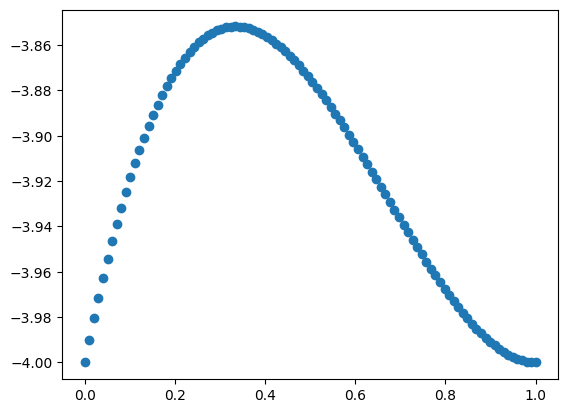

In [ ]:
import numpy as np
def generate_noisylinear_data(N):
    x = np.linspace(0,1,N)
    y = 2*x + 1 + np.random.normal(0,0.2,N)
    return  x,y
def generate_polynomial_data(N):
    x = np.linspace(0,1,N)
    y = x**3 - 2*x**2+x-4.0
    return  x,y
def generate_smoothfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.sin(2.*np.pi*x)
    # modify function here
    return  x,y
def generate_stepfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.float32(x>0.5)
    return  x,y

# Visualize the data
import matplotlib.pyplot as plt
[xdata,ydata] = generate_polynomial_data(100)
plt.plot(xdata,ydata,'o')

We will build up a tensor which contains all of our functions. The output will be a tensor $\text{data_tensor}_{ijk}$ where $i$ denotes which function, $j$ the x or y, and $k$ which $(x_k,y_k)$ pair.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate data
N = 100  # Number of data points
x_noisylinear, y_noisylinear = generate_noisylinear_data(N)
x_polynomial, y_polynomial = generate_polynomial_data(N)
x_smooth, y_smooth = generate_smoothfunction_data(N)
x_step, y_step = generate_stepfunction_data(N)

# Convert to PyTorch tensors
x_noisylinear_tensor = torch.tensor(x_noisylinear, dtype=torch.float32)
y_noisylinear_tensor = torch.tensor(y_noisylinear, dtype=torch.float32)
x_polynomial_tensor = torch.tensor(x_polynomial, dtype=torch.float32)
y_polynomial_tensor = torch.tensor(y_polynomial, dtype=torch.float32)
x_smooth_tensor = torch.tensor(x_smooth, dtype=torch.float32)
y_smooth_tensor = torch.tensor(y_smooth, dtype=torch.float32)
x_step_tensor = torch.tensor(x_step, dtype=torch.float32)
y_step_tensor = torch.tensor(y_step, dtype=torch.float32)

# Combine data into a single tensor
data_tensor = torch.stack([
    torch.stack([x_noisylinear_tensor, y_noisylinear_tensor]),
    torch.stack([x_polynomial_tensor, y_polynomial_tensor]),
    torch.stack([x_smooth_tensor, y_smooth_tensor]),
    torch.stack([x_step_tensor, y_step_tensor])
])

print(data_tensor.shape) # Output: torch.Size([4, 2, 100])

torch.Size([4, 2, 100])


## Part 2: Solve with linear algebra ##

First we will write code to evaluate a polynomial basis of a given order on the given data points

In [ ]:
def build_polynomial_basis(points, degree):
  N = points.shape[0]
  basis = torch.zeros(N, degree + 1)
  for i in range(degree + 1):
    basis[:, i] = points ** i
  return basis

#example usage
degree = 4
xpoints = data_tensor[0,0,:]
basis = build_polynomial_basis(xpoints, degree)
print(basis.shape)

torch.Size([100, 5])


Next we will build up the linear systems for a least squares solve:
$$ \mathbf{A} \mathbf{c} := \sum_d P_\alpha(x_d) P_\beta(x_d) c_\beta = \sum_d P_\alpha(x_d) := \mathbf{b}$$

In [ ]:
A_mat = torch.einsum('da,db->ab',basis,basis)
b_vec = torch.einsum('da,fd->af',basis,data_tensor[:,1,:])
c_vec = torch.linalg.solve(A_mat,b_vec)

Finally we'll visualize to check what sort of fit we've gotten

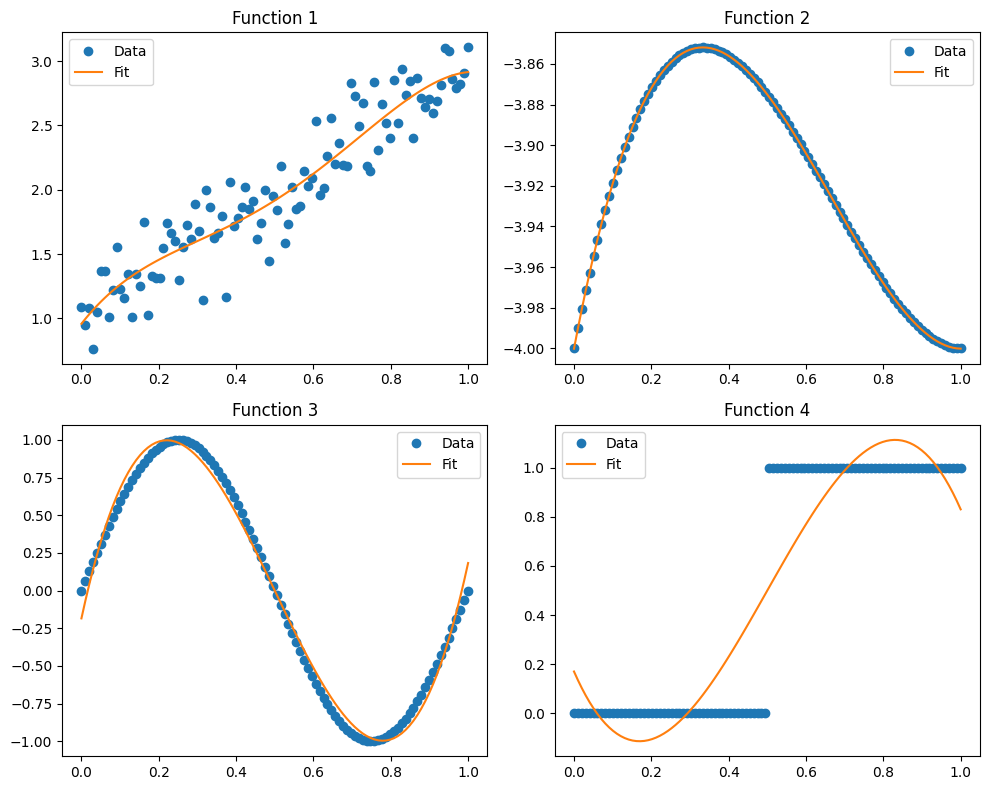

In [ ]:
import matplotlib.pyplot as plt

#evaluate the fit function
y_fit = torch.einsum('da,af->fd', basis, c_vec)

# make some plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(4):
    x_data = data_tensor[i, 0, :]
    y_data = data_tensor[i, 1, :]
    fitplot = y_fit[i,:]

    axes[i].plot(x_data.detach().numpy(), y_data.detach().numpy(), 'o', label='Data')
    axes[i].plot(x_data.detach().numpy(), fitplot.detach().numpy(), '-', label='Fit')
    axes[i].set_title(f'Function {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Rerun this code with different choices of polynomial order. You'll see a tradeoff - a large polynomial order will help with function 3 but will give over/undershoots near the discontinuity for function 4. High order polynomials are great for smooth functions but not discontinuous ones - can we find a different basis that works well for both?

## Part 3: Solve as a pytorch model ##

The following will do the exact same, but using gradient descent and a neural network to fit the functions instead.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model (in our case, its y = A*x + b)
class NeuralNetworkLayer(nn.Module):
    def __init__(self):
        super(NeuralNetworkLayer, self).__init__()
        # Define a simple MLP with two hidden layer
        self.Nneurons = 40
        self.hidden1 = nn.Linear(1, self.Nneurons)  # 1 input feature, N hidden units
        self.hidden2 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        self.output = nn.Linear(self.Nneurons, 1)  # N hidden units, 1 output feature

    def forward(self, x):
        # We use the ReLU activation function for the hidden layer
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

With the model defined, we will now initialize it and pick a loss function and an optimizer

In [ ]:
# Instantiate the custom layer
layer = NeuralNetworkLayer()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(layer.parameters(), lr=0.01)


The following will fit the network to any one of the functions in the dataset. Try playing around with this by switching different functions by choosing dataindex = 1,2,3,4. Play with the learning rate, number of steps. Play with the activation function to switch from a torch.relu to a torch.tanh activation.

Epoch [1/10000], Loss: 15.0646
Epoch [1001/10000], Loss: 0.0001
Epoch [2001/10000], Loss: 0.0001
Epoch [3001/10000], Loss: 0.0000
Epoch [4001/10000], Loss: 0.0000
Epoch [5001/10000], Loss: 0.0000
Epoch [6001/10000], Loss: 0.0000
Epoch [7001/10000], Loss: 0.0000
Epoch [8001/10000], Loss: 0.0000
Epoch [9001/10000], Loss: 0.0000


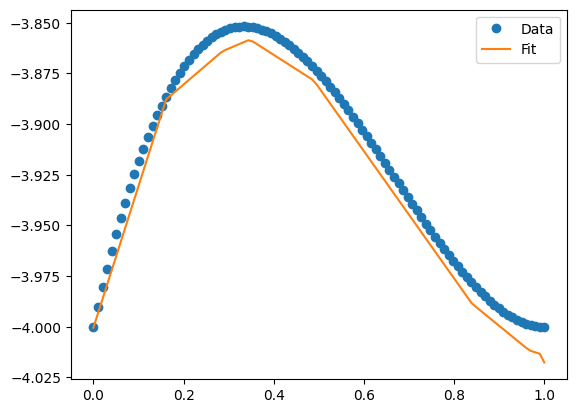

In [ ]:
# Choose which function to fit the network to
dataindex = 1
x_data = data_tensor[dataindex,0,:]
y_data = data_tensor[dataindex,1,:]


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = layer(x_data.unsqueeze(-1)).squeeze(-1)
    loss = criterion(outputs, y_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(x_data.detach().numpy(), y_data.detach().numpy(), 'o', label='Data')
plt.plot(x_data.detach().numpy(), outputs.detach().numpy(), '-', label='Fit')
plt.legend()

## Part 4: Mix parts 3 and 4 to solve for an optimal basis ##

What we would really like is to find a model that could fit any one of the functions well. The neural network (at least how its set up right now) can only get trained to fit a single function. It then needs to get retrained to fit additional functions. In the following I'll step you through how you can use the neural network to build up a learnable basis, but still use standard least square linear algebra to make sure it fits all of the functions equally well.

In [ ]:
# Define the model (in our case, its y = A*x + b)
class BasisDNNLayer(nn.Module):
    def __init__(self,Nbasis):
        super(BasisDNNLayer, self).__init__()
        # Define a simple MLP with two hidden layer
        self.Nneurons = 40
        self.hidden1 = nn.Linear(1, self.Nneurons)  # 1 input feature, N hidden units
        self.hidden2 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        self.output = nn.Linear(self.Nneurons, Nbasis)  # N hidden units, 1 output feature

    def forward(self, x):
        # We use the ReLU activation function for the hidden layer
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [ ]:
# Instantiate the custom layer
layer = BasisDNNLayer(4)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(layer.parameters(), lr=0.001)

In [ ]:


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    basis = layer(x_data.unsqueeze(-1)).squeeze(-1)
    A_mat = torch.einsum('da,db->ab',basis,basis)
    b_vec = torch.einsum('da,fd->af',basis,data_tensor[:,1,:])
    c_vec = torch.linalg.solve(A_mat,b_vec)
    y_fit = torch.einsum('da,af->fd', basis, c_vec)
    error = y_fit-data_tensor[:,1,:]
    loss = torch.mean(error**2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.0329
Epoch [1001/10000], Loss: 0.0096
Epoch [2001/10000], Loss: 0.0091
Epoch [3001/10000], Loss: 0.0089
Epoch [4001/10000], Loss: 0.0092
Epoch [5001/10000], Loss: 0.0086
Epoch [6001/10000], Loss: 0.0087
Epoch [7001/10000], Loss: 0.0085
Epoch [8001/10000], Loss: 0.0087
Epoch [9001/10000], Loss: 0.0082


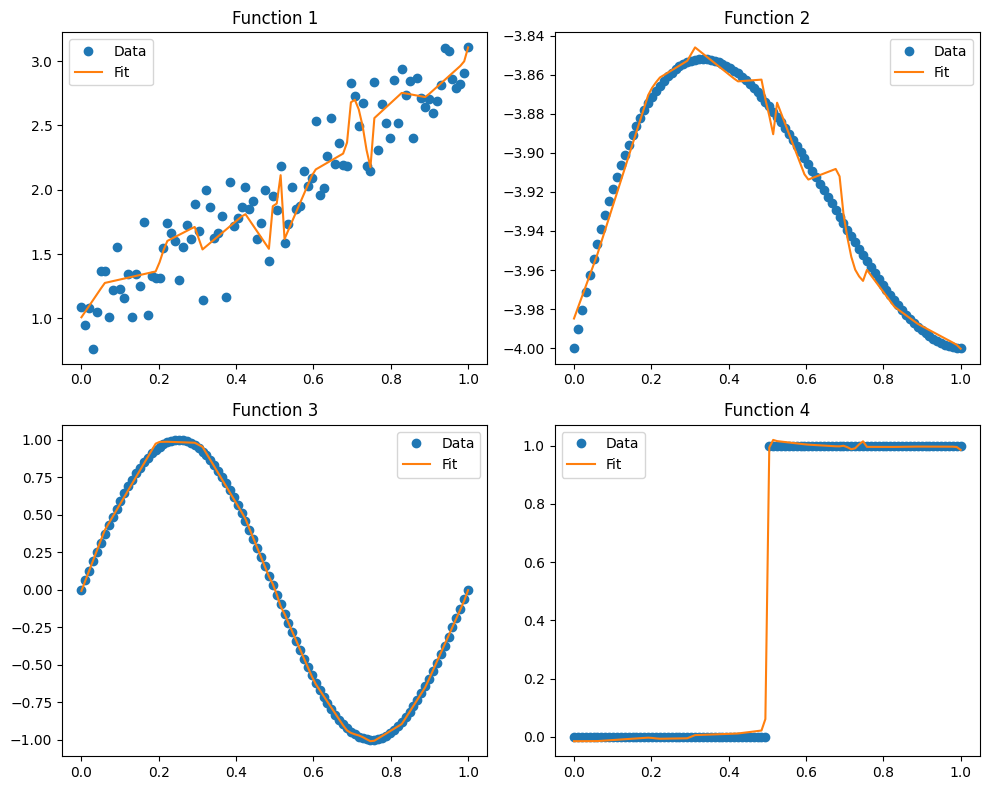

In [ ]:
import matplotlib.pyplot as plt

#evaluate the fit function
y_fit = torch.einsum('da,af->fd', basis, c_vec)

# make some plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(4):
    x_data = data_tensor[i, 0, :]
    y_data = data_tensor[i, 1, :]
    fitplot = y_fit[i,:]

    axes[i].plot(x_data.detach().numpy(), y_data.detach().numpy(), 'o', label='Data')
    axes[i].plot(x_data.detach().numpy(), fitplot.detach().numpy(), '-', label='Fit')
    axes[i].set_title(f'Function {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()